In [1]:
import pandas as pd
import spacy
import steamreviews
import json
import csv
import os
import glob
import json
import matplotlib.pyplot as plt
import nltk
import wordcloud
import re
import plotly
import seaborn as sns
import stanza
import string 
import joblib

from scipy.stats import pearsonr
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from wordcloud import WordCloud
from pandas.io.json import json_normalize
from nltk.corpus import stopwords
from tqdm.notebook import trange, tqdm
from sklearn.cluster import KMeans

C:\Users\marty\AppData\Local\Programs\Python\Python311\Lib\site-packages\thinc\compat.py:36: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  hasattr(torch, "has_mps")
C:\Users\marty\AppData\Local\Programs\Python\Python311\Lib\site-packages\thinc\compat.py:37: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  and torch.has_mps  # type: ignore[attr-defined]


## Reviews download
https://pypi.org/project/steamreviews/

In [2]:
dir_name = "data"
reviews_jsons = glob.glob(f"{dir_name}/*")
reviews_jsons

['data\\review_1150690.json',
 'data\\review_1172620.json',
 'data\\review_1341290.json',
 'data\\review_1515210.json',
 'data\\review_210970.json',
 'data\\review_219150.json',
 'data\\review_219890.json',
 'data\\review_250320.json',
 'data\\review_257510.json',
 'data\\review_262060.json',
 'data\\review_289070.json',
 'data\\review_294100.json',
 'data\\review_304430.json',
 'data\\review_394360.json',
 'data\\review_400.json',
 'data\\review_427520.json',
 'data\\review_460950.json',
 'data\\review_550.json',
 'data\\review_620.json',
 'data\\review_632470.json',
 'data\\review_646570.json',
 'data\\review_736260.json',
 'data\\review_860510.json']

In [3]:
title_dict = {"219150": "Hotline Miami",
              "1172620" : "Sea of Thieves",
              "460950" : "Katana ZERO",
              "262060" : "Darkest Dungeon",
              "250320" : "The Wolf Among Us",
              "210970" : "The Witness",
              "620" : "Portal 2",
              "736260" : "Baba Is You",
              "219890" : "Antichamber",
              "289070" : "Sid Meier's Civilization VI",
              "427520" : "Factorio",
              "257510" : "The Talos Principle",
             "304430" : "INSIDE",
             "400" : "Portal",
             "394360" : "Hearts of Iron IV",
             "632470" : "Disco Elysium",
             "294100" : "RimWorld",
              "646570" : "Slay the Spire",
              "1150690" : "Omori",
              "1341290" : "We Were Here Forever",
              "1515210" : "The Past Within",
              "860510" : "Little Nightmares II",
              "550" : "Left 4 Dead 2"}

In [4]:
genre_dict = {"219150": "A",
              "1172620" : "A",
              "460950" : "A",
              "262060" : "R",
              "250320" : "R",
              "210970" : "P",
              "620" : "P",
              "736260" : "P",
              "219890" : "P",
              "289070" : "S",
              "427520" : "S",
              "257510" : "P",
              "304430" : "P",
             "400" : "P",
             "394360" : "S",
             "632470" : "R",
             "294100" : "S",
             "646570" : "R",
             "1150690" : "R",
             "1341290" : "P",
             "1515210" : "P",
             "860510" : "P",
             "550" : "A"}

In [5]:
data_list = []
for i in reviews_jsons:
    with open(i, encoding = "utf-8") as json_file:
        json_data = json.load(json_file)
        reviews = json_data['reviews']
        file_name = json_file.name.split('.')[0].split('_')[1]
        for key in reviews.keys():
            data_list.append([title_dict.get(file_name),genre_dict.get(file_name),reviews[key]['author']['steamid'], reviews[key]['votes_up'], 
                          reviews[key]['review'], reviews[key]['weighted_vote_score'], reviews[key]['voted_up'],
                          reviews[key]['author']['num_games_owned'], reviews[key]['author']['playtime_at_review'],
                          reviews[key]['author']['num_reviews'], 
                          reviews[key]["timestamp_created"] ])
df = pd.DataFrame(data_list, columns = ["title", "genre","steamid", "votes_up", "review", "weighted_vote_score", "voted_up",
                                        "num_games_owned", "playtime_at_review", "num_reviews", "timestamp_created"])

In [6]:
df.sample(frac=0.3).head()

,title,genre,steamid,votes_up,review,weighted_vote_score,voted_up,num_games_owned,playtime_at_review,num_reviews,timestamp_created
7428,Hotline Miami,A,76561198292914642,31,this game is what i imagine myself doing if th...,0.744981288909912109,True,0,1583,55,1689648262
9261,Darkest Dungeon,R,76561198864568682,1,Give them no quarter,0.523809552192687988,True,124,1671,73,1687516272
28456,Disco Elysium,R,76561198044802260,2,This is the only game where I got a gameover i...,0.545454561710357666,True,0,3312,3,1667584193
13685,RimWorld,S,76561198284460055,2,everytime i play this game and my friends ask ...,0.52173912525177002,True,116,15207,20,1679514687
28000,Disco Elysium,R,76561199380149526,86,i can punch kids,0.847494661808013916,True,16,1654,5,1695123325


In [7]:
df['timestamp_created'] = pd.to_datetime(df['timestamp_created'], unit='s')

## Preprocessing

1. Braki danych
2. Usunięcie duplikatów
4. Usunięcie recenzjii krótszych niż 3 słowa
9. Usunięcie znaków spcjalnych 
10. "Text lowering"
6. Usunięcie znaków interpunkcyjnych i liczb
8. Usunięcie tytułów gier z recenzji
7. Tokenizacja
8. Part-of-speech tagging
9. Lematyzacja

#### Braki danych

In [8]:
df.isna().sum()

title                  0
genre                  0
steamid                0
votes_up               0
review                 0
weighted_vote_score    0
voted_up               0
num_games_owned        0
playtime_at_review     0
num_reviews            0
timestamp_created      0
dtype: int64

#### Usunięcie duplikatów

In [9]:
df.duplicated(subset='review').sum()

2580

In [10]:
df[df.duplicated(subset='review')].sample(20)

,title,genre,steamid,votes_up,review,weighted_vote_score,voted_up,num_games_owned,playtime_at_review,num_reviews,timestamp_created
22425,Left 4 Dead 2,A,76561199485511744,1,is nice,0.523809552192687988,True,0,297,2,2023-10-02 15:59:16
13214,RimWorld,S,76561198111332089,1,its ok,0.523809552192687988,True,260,41647,2,2022-12-12 16:17:17
13074,RimWorld,S,76561198216892453,1,good,0.523809552192687988,True,129,71627,28,2023-01-21 16:54:10
4585,Sea of Thieves,A,76561199384880060,1,fun game,0.523809552192687988,True,0,3390,5,2022-11-22 16:57:36
19844,Factorio,S,76561198387637448,1,,0.523809552192687988,True,198,3158,75,2023-06-30 23:49:34
18152,Portal,P,76561199525507481,1,,0.523809552192687988,True,0,376,1,2023-08-17 02:45:14
21753,Left 4 Dead 2,A,76561199083085395,235,⣿⣿⣿⣿⣿⣿⣿⣿⠟⠋⠁⠀⠀⠀⠀⠀⠀⠀⠀⠉⠻⣿\n⣿⣿⣿⣿⣿⣿⣿⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢺...,0.852275967597961426,True,50,4773,10,2023-02-18 00:46:09
20857,Factorio,S,76561198192834151,2,The factory must grow,0.50559699535369873,True,126,50899,2,2022-10-18 04:00:35
22032,Left 4 Dead 2,A,76561198952398465,2,Masterpiece.,0.545454561710357666,True,0,324,1,2023-04-03 20:22:44
13032,RimWorld,S,76561198142127991,1,a,0.523809552192687988,True,0,7815,1,2023-02-02 00:00:32


In [11]:
(df.duplicated(subset='review') == False).sum()

29492

In [12]:
df = df[df.duplicated(subset='review') == False]

In [13]:
df.duplicated(subset='review').sum()

0

#### Długość recenzji

In [14]:
df["temp_review_len"] = df["review"].apply(lambda x: x.split(" ").__len__())
df["temp_review_len"].describe()

count    29492.000000
mean        54.191984
std        135.354534
min          1.000000
25%          5.000000
50%         13.000000
75%         39.000000
max       3997.000000
Name: temp_review_len, dtype: float64

In [15]:
df[df["temp_review_len"] < 4].groupby(by=["genre"]).count()

,title,steamid,votes_up,review,weighted_vote_score,voted_up,num_games_owned,playtime_at_review,num_reviews,timestamp_created,temp_review_len
genre,,,,,,,,,,,
A,1659,1659,1659,1659,1659,1659,1659,1659,1659,1659,1659
P,852,852,852,852,852,852,852,852,852,852,852
R,798,798,798,798,798,798,798,798,798,798,798
S,1140,1140,1140,1140,1140,1140,1140,1140,1140,1140,1140


In [16]:
df = df[df["temp_review_len"] >= 3]

In [17]:
suma = 0
for i in df["temp_review_len"]:
    suma += i

In [18]:
print("Ilość słów:", suma,
     "Ilość recenzji:", len(df["temp_review_len"]))

Ilość słów: 1593992 Ilość recenzji: 26663


In [19]:
df = df.drop(["temp_review_len"], axis=1)

### Wordcloud

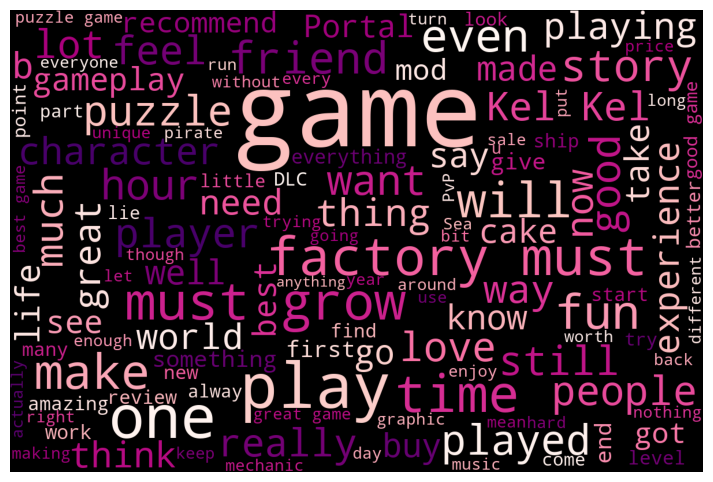

In [20]:
txt = ' '.join(i for i in df["review"])
wordcloud = WordCloud(max_font_size = 180,
                max_words = 120,
                width = 1200,
                height = 800,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

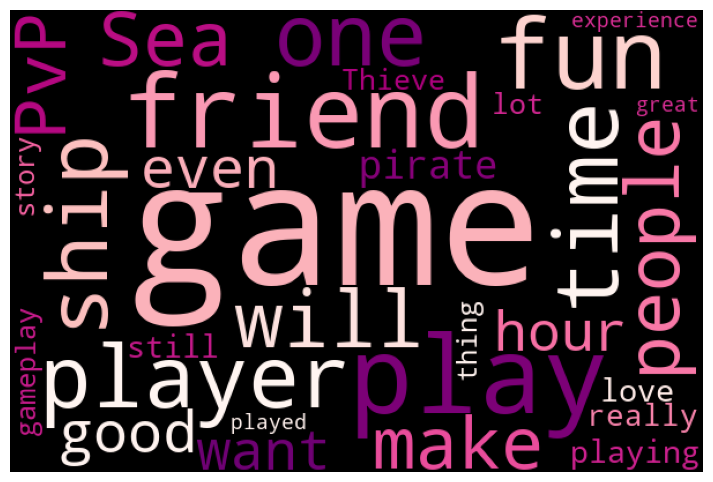

In [21]:
txt = ' '.join(i for i in df[df['genre'] == "A"]['review'])
wordcloud = WordCloud(max_font_size = 150,
                max_words = 30,
                width = 600,
                height = 400,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

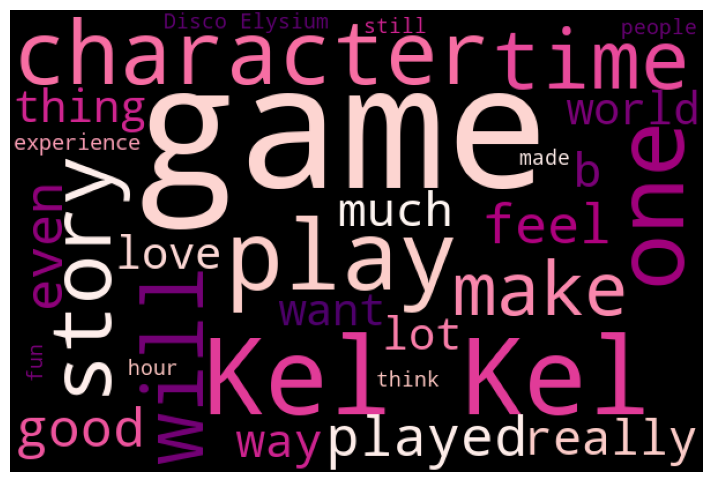

In [22]:
txt = ' '.join(i for i in df[df['genre'] == "R"]['review'])
wordcloud = WordCloud(max_font_size = 150,
                max_words = 30,
                width = 600,
                height = 400,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

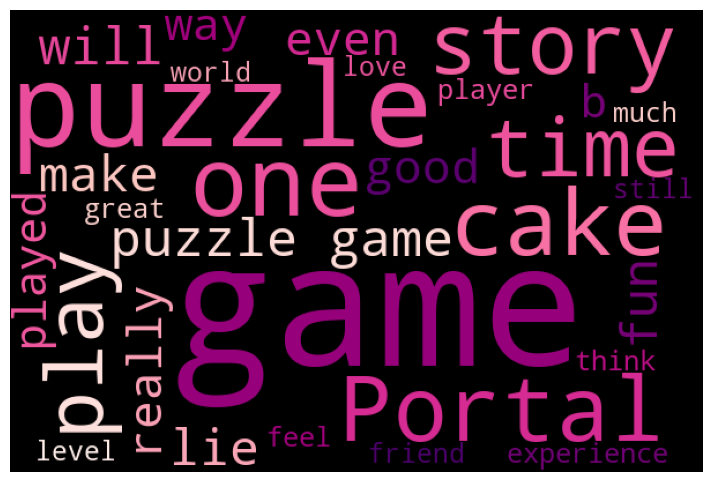

In [23]:
txt = ' '.join(i for i in df[df['genre'] == "P"]['review'])
wordcloud = WordCloud(max_font_size = 150,
                max_words = 30,
                width = 600,
                height = 400,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

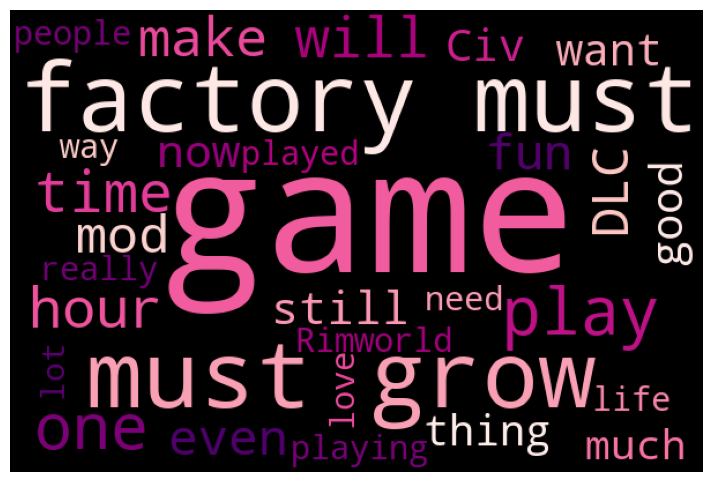

In [24]:
txt = ' '.join(i for i in df[df['genre'] == "S"]['review'])
wordcloud = WordCloud(max_font_size = 150,
                max_words = 30,
                width = 600,
                height = 400,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

#### Usunięcie znaków, text lowering

In [25]:
df["review"] = df["review"].str.replace(r"\[.*?\]|\n|[^\x00-\x7F]+", "", regex=True).str.lower()

In [26]:
df["review"].sample(10)

4988                            this game is too addicting
2733     artstyle and animations are great, the core ga...
11247                         hehe tech boost funny moment
24879    its ok :3333im gonna kill myself i been alone ...
3737     originally a positive review but the game is f...
10789    the multiplayer mode is totally shit, full of ...
14151    rescued an ugly woman from some ancients. raid...
13148    almost had 100 hours into the game in the firs...
17989                               watch your every step.
6910     i've really enjoyed my time with this game. it...
Name: review, dtype: object

#### Usunięcie znaków interpunkcyjnych i liczb

In [27]:
df["review"] = df["review"].str.replace(r"[0-9]", "", regex=True)

In [28]:
df["review"] = df["review"].str.replace('['  + string.punctuation + ']', "", regex =True)

In [29]:
df["review"].sample(5)

10182    fun game lots of different ways to play from s...
29880    the best storybase rpg game i ever play but pu...
13423                       cool game fun workshop etc etc
7544        fast twinstick shooter accompanied by top n...
27960     novels worth of political commentary and exis...
Name: review, dtype: object

#### Usunięcie tytułów gier z recenzji

In [30]:
for value in title_dict.values():
    df["review"] = df["review"].str.replace(value.lower(), "")

#### Tokenizacja

In [31]:
df["tokenized"] = df["review"].apply(nltk.word_tokenize)

In [32]:
df["tokenized"].sample(15)

26705                    [like, but, harder, and, funnier]
1205     [wow, what, a, happy, and, cheery, game, i, lo...
29209    [this, game, is, one, of, the, most, innovativ...
12067               [played, a, little, its, pretty, good]
9043     [schizophrenia, inducing, neanderthal, menagme...
3791     [i, thieved, the, sea, or, something, like, that]
22796    [this, game, is, so, good, i, like, to, play, ...
27057    [one, of, the, greatest, video, games, of, all...
17017                                   [fuck, this, game]
22851                                   [real, mens, game]
3937     [extremely, fun, game, and, near, infinite, pl...
6171     [this, franchise, needs, to, continue, we, nee...
19089                                                [pls]
8091     [the, only, game, where, i, have, the, biggest...
6630     [this, game, was, an, amazing, coop, experienc...
Name: tokenized, dtype: object

### Stopwords

In [33]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
english_stopwords = stopwords.words('english')
english_stopwords_cleaned = [word.replace("'", "") for word in english_stopwords]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marty\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
new_column = []
for row in df["tokenized"]:
    new_row = [word for word in row if word[0] not in english_stopwords_cleaned]
    new_column.append(new_row)
df["final_review"] = new_column

## Describe

In [35]:
df.dtypes

title                          object
genre                          object
steamid                        object
votes_up                        int64
review                         object
weighted_vote_score            object
voted_up                         bool
num_games_owned                 int64
playtime_at_review              int64
num_reviews                     int64
timestamp_created      datetime64[ns]
tokenized                      object
final_review                   object
dtype: object

In [36]:
df["weighted_vote_score"] = pd.to_numeric(df["weighted_vote_score"])

In [37]:
df["voted_up"] = pd.to_numeric(df["voted_up"])

In [38]:
df.describe()

,votes_up,weighted_vote_score,num_games_owned,playtime_at_review,num_reviews
count,26663.000000,26663.000000,26663.000000,2.666300e+04,26663.000000
mean,31.715148,0.570098,140.866707,1.309372e+04,21.467689
std,173.097223,0.109932,538.652824,4.720263e+04,59.809381
min,0.000000,0.500000,0.000000,5.000000e+00,1.000000
25%,1.000000,0.521739,0.000000,5.350000e+02,3.000000
50%,1.000000,0.523810,0.000000,1.800000e+03,8.000000
75%,3.000000,0.545180,113.000000,7.111500e+03,20.000000
max,9568.000000,0.987843,22780.000000,1.890626e+06,3419.000000


C:\Users\marty\AppData\Local\Temp\ipykernel_16884\2852639080.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr(method = "pearson")


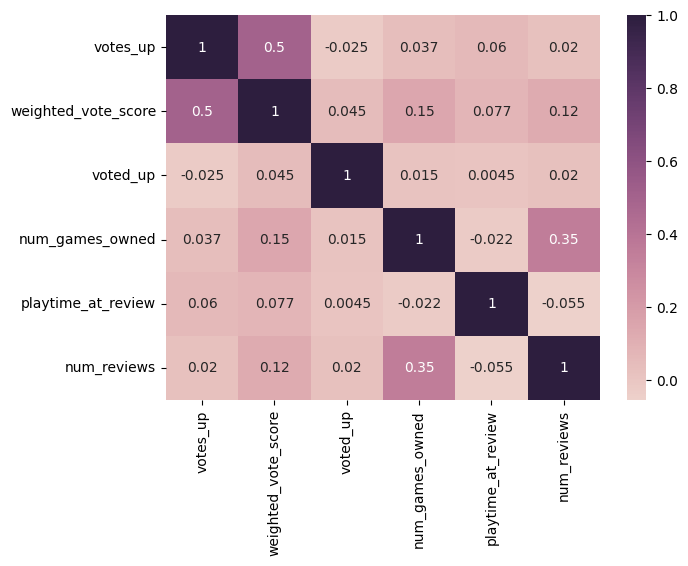

In [39]:
corr = df.corr(method = "pearson")
plt.figure(figsize=(7,5))
sns.heatmap(corr, cmap=sns.cubehelix_palette(as_cmap=True),annot=True)
plt.show()

## Wykresy

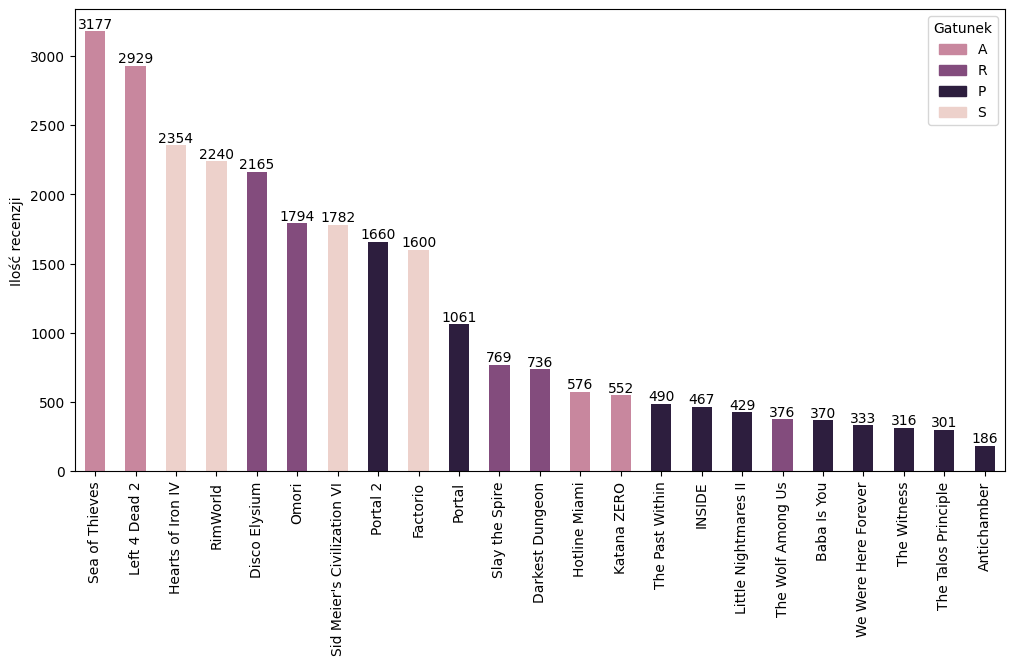

In [40]:
value_counts_title = df["title"].value_counts()
genre_colors = {"A": sns.cubehelix_palette(4)[1], "R": sns.cubehelix_palette(4)[2], "P": sns.cubehelix_palette(4)[3], 
                "S": sns.cubehelix_palette(4)[0]}
df['color'] = df['genre'].map(genre_colors)
colors = [df.loc[df['title'] == title]['color'].iloc[0] for title in value_counts_title.index]

plt.figure(figsize=(12, 6))
x = value_counts_title.plot(kind = "bar", color = colors)
plt.ylabel("Ilość recenzji")
plt.xticks(rotation = 90)
for i, count in enumerate(value_counts_title):
    x.text(i, count, count, va = "bottom", ha = "center")

handles = [plt.Rectangle((0,0), 1,1, color=genre_colors[label]) for label in genre_colors]
plt.legend(handles, genre_colors.keys(), title="Gatunek", loc="upper right")


plt.show()
df = df.drop(["color"], axis=1)

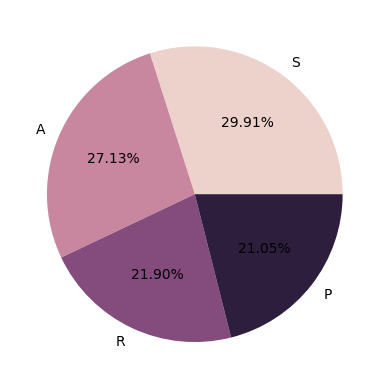

In [41]:
value_counts_genre = df["genre"].value_counts()
colors = sns.cubehelix_palette(4)
x = plt.pie(value_counts_genre, labels = value_counts_genre.index, colors=colors, autopct='%1.2f%%')
plt.show()

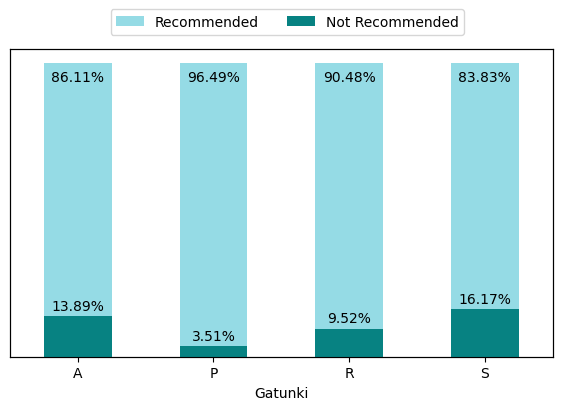

In [42]:
value_counts_recommendation_genre = df.groupby('genre').voted_up.value_counts().unstack(0)
percentage_pos = value_counts_recommendation_genre.iloc[1] / (value_counts_recommendation_genre.iloc[1] + value_counts_recommendation_genre.iloc[0]) * 100 
percentage_neg = value_counts_recommendation_genre.iloc[0] / (value_counts_recommendation_genre.iloc[0] + value_counts_recommendation_genre.iloc[1]) * 100 

total_count = percentage_pos + percentage_neg

def addlabels_neg(x,y):
    for i in range(len(y)):
        plt.text(i, x[i] + 2, f"{x[i]:.2f}%",  ha = "center")

def addlabels_pos(x,y):
    for i in range(len(y)):
        plt.text(i, x[i] - 6, f"{y[i]:.2f}%",  ha = "center")

fig, ax1 = plt.subplots(figsize=(7, 4))
ax2 = ax1.twinx()

total_count.plot(kind="bar", color="#95DBE5FF",  label="Recommended")
percentage_neg.plot(kind="bar", color="#078282FF", label="Not Recommended")

ax1.set_xlabel("Gatunki")
ax1.tick_params(axis="y", left=False, labelleft=False)
ax2.tick_params(axis="y", right=False, labelright=False)

addlabels_neg(percentage_neg, total_count) 
addlabels_pos(total_count, percentage_pos) 

plt.legend(bbox_to_anchor=(0.85, 1.15), ncol=2)
plt.show()

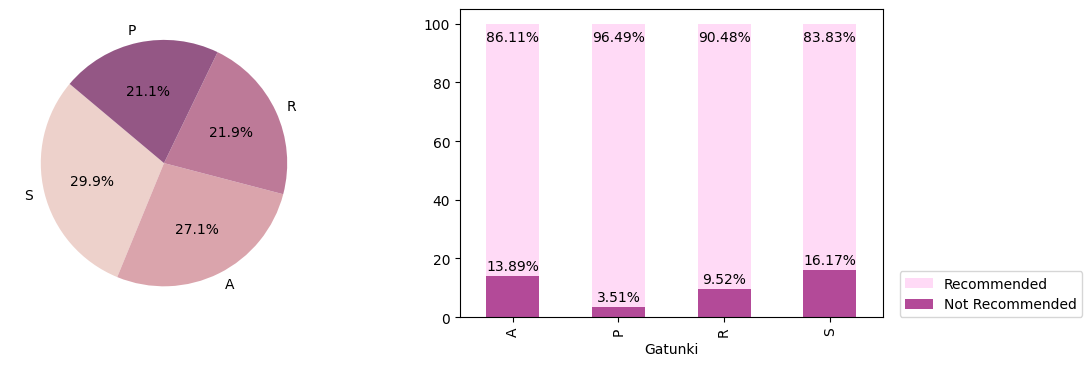

In [43]:
import numpy as np

value_counts_recommendation_genre = df.groupby('genre').voted_up.value_counts().unstack(0)
percentage_pos = value_counts_recommendation_genre.iloc[1] / (value_counts_recommendation_genre.iloc[1] + value_counts_recommendation_genre.iloc[0]) * 100 
percentage_neg = value_counts_recommendation_genre.iloc[0] / (value_counts_recommendation_genre.iloc[0] + value_counts_recommendation_genre.iloc[1]) * 100 

total_count = percentage_pos + percentage_neg

def addlabels_neg(x,y):
    for i in range(len(y)):
        plt.text(i, x[i] + 2, f"{x[i]:.2f}%",  ha = "center")

def addlabels_pos(x,y):
    for i in range(len(y)):
        plt.text(i, x[i] - 6, f"{y[i]:.2f}%",  ha = "center")

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

total_count.plot(kind="bar", color="#ffdaf6",  label="Recommended")
percentage_neg.plot(kind="bar", color="#b34a98", label="Not Recommended")

axs[1].set_xlabel("Gatunki")
addlabels_neg(percentage_neg, total_count) 
addlabels_pos(total_count, percentage_pos) 
axs[1].legend(loc=(1.04, 0))

value_counts_genre = df["genre"].value_counts()
colors = sns.cubehelix_palette(6)

axs[0].pie(value_counts_genre, labels = value_counts_genre.index,colors=colors, autopct='%1.1f%%', startangle=140)
plt.show()

## Dependency parser test

In [44]:
test = [df["final_review"][6543], df["final_review"][4534], df["final_review"][12345], df["final_review"][12354],
        df["final_review"][1925], df["final_review"][1067],df["final_review"][22951],df["final_review"][2231],
       ["not","fun", "gameplay"], df["tokenized"][832], df["final_review"][21], df["tokenized"][27061],
       df["final_review"][11088], df["final_review"][3171], df["final_review"][7834], df["final_review"][20180],
       df["final_review"][6697], df["final_review"][893]]

In [45]:
import stanza
nlp = stanza.Pipeline('en', tokenize_pretokenized=True) 
doc = nlp(test)

2024-07-11 15:08:59 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-07-11 15:08:59 INFO: Downloaded file to C:\Users\marty\stanza_resources\resources.json
2024-07-11 15:09:00 INFO: Loading these models for language: en (English):
| Processor    | Package                   |
--------------------------------------------
| tokenize     | combined                  |
| mwt          | combined                  |
| pos          | combined_charlm           |
| lemma        | combined_nocharlm         |
| constituency | ptb3-revised_charlm       |
| depparse     | combined_charlm           |
| sentiment    | sstplus_charlm            |
| ner          | ontonotes-ww-multi_charlm |

2024-07-11 15:09:00 INFO: Using device: cuda
2024-07-11 15:09:00 INFO: Loading: tokenize
2024-07-11 15:09:00 INFO: Loading: mwt
2024-07-11 15:09:01 INFO: Loading: pos
2024-07-11 15:09:01 INFO: Loading: lemma
2024-07-11 15:09:01 INFO: Loading: constituency
2024-07-11 15:09:02 INFO: Loading: depparse
2024-07-11 15:09:02 INFO: Loading: sentiment
2024-07-11 15:09:02 INFO: Loading: ne

In [46]:
dependency_list = []
for dependency in doc.sentences[13].dependencies:
    dependency_list.append([dependency[2].text, dependency[0].id, dependency[1]])
    
for i in range(0, len(dependency_list)):
    if (int(dependency_list[i][1]) != 0):
        dependency_list[i][1] = test[13][(int(dependency_list[i][1]) - 1)]

print(*dependency_list[:10], sep='\n')

['crewing', 0, 'root']
['game', 'value', 'compound']
['value', 'crewing', 'obj']
['likely', 'crewing', 'advmod']
['worthless', 'crewing', 'xcomp']
['real', 'crewing', 'xcomp']
['but', 'play', 'cc']
['can', 'play', 'aux']
['play', 'crewing', 'conj']
['player', 'play', 'obj']


In [47]:
feature_list = []
feature_opinion_list = [] 

for dependency in doc.sentences[13].dependencies:
    if dependency[2].xpos == "RB":
        opinion_word = dependency[2]
        rb_adj = dependency[0]
        
    if (dependency[2].xpos in ["NN", "NNS","JJ", "JJS", "JJR"]) and (dependency[1] in ["amod"]):
        if dependency[0] == rb_adj or dependency[2] == rb_adj:
            if dependency[2].xpos in ["JJS", "JJR"]:
                result_dict = {'feature': dependency[0].lemma, 'opinion': opinion_word.text + " " + dependency[2].text}
            else:
                result_dict = {'feature': dependency[0].lemma, 'opinion': opinion_word.text + " " + dependency[2].lemma}     
        else:
            if dependency[2].xpos in ["JJS", "JJR"]:
                result_dict = {'feature': dependency[0].lemma, 'opinion': dependency[2].text}
            else:
                result_dict = {'feature': dependency[0].lemma, 'opinion': dependency[2].lemma}  

        feature_list.append(dependency[0].lemma)
        feature_opinion_list.append(result_dict)

print(f'Feature list: {feature_list}')
print(f'Feature-opinion list: {feature_opinion_list}')

Feature list: ['graphic', 'beauty', 'player', 'player', 'player', 'guide', 'reward', 'reward', 'reward']
Feature-opinion list: [{'feature': 'graphic', 'opinion': 'fun'}, {'feature': 'beauty', 'opinion': 'real'}, {'feature': 'player', 'opinion': 'unbalanced'}, {'feature': 'player', 'opinion': 'janky'}, {'feature': 'player', 'opinion': 'human'}, {'feature': 'guide', 'opinion': 'necessary'}, {'feature': 'reward', 'opinion': 'risky'}, {'feature': 'reward', 'opinion': 'lowest'}, {'feature': 'reward', 'opinion': 'highest'}]


## Dependency parser final

In [48]:
with open('opinions.json', 'r') as file:
    dct = json.load(file)

In [49]:
feature_list = []

for i in range(len(df)):
    index = str(i)  
    feature = dct.get(index)
    if feature is None:
        feature_list.append([])
    else:
        feature_list.append(feature)

df["feature"] = feature_list

In [50]:
words = []
for i in df["feature"]:
    for j in i:
        words.append(j["feature"])

In [51]:
unique_words = list(set(words))

In [52]:
word_counts = pd.DataFrame([[i, len([q for q in words if q==i])] for i in unique_words], 
              columns=['word', 'count']).sort_values('count', ascending=False)

## Dendrogram

In [53]:
popular_words = word_counts[word_counts['count']>= 15]["word"].to_list()
nlp = spacy.load('en_core_web_md')
tokens = [nlp(word) for word in popular_words]
word_vectors = pd.DataFrame([i.vector for i in tokens])

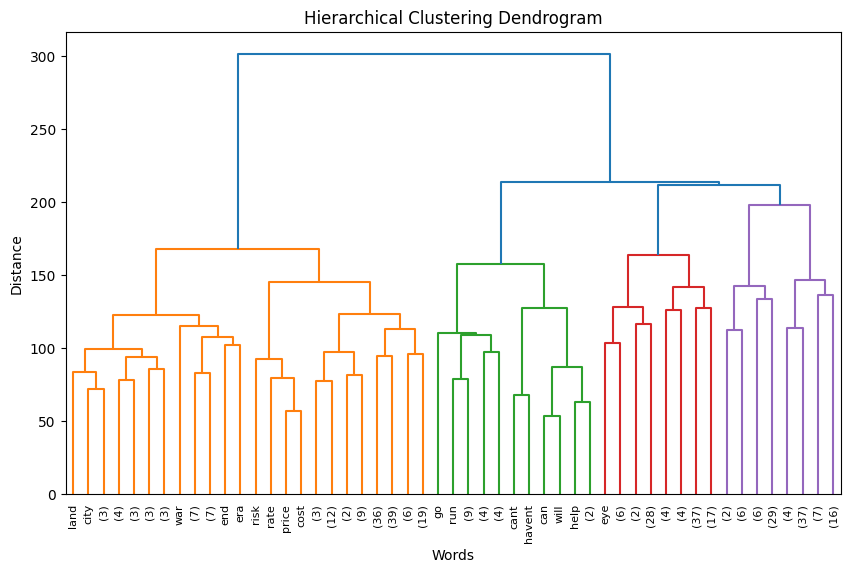

In [54]:
Z = linkage(word_vectors.values, method='ward')

plt.figure(figsize=(10,6))
dendrogram(Z, p = 5, truncate_mode = "level", orientation='top', labels = popular_words, leaf_font_size = 8)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Words')
plt.ylabel('Distance')
plt.show()

In [55]:
cluster_labels = fcluster(Z, t = 75,  criterion="distance")

clusters = {}
for word, label in zip(popular_words, cluster_labels):
    if label not in clusters:
        clusters[label] = [word]
    else:
        clusters[label].append(word)

for label, words in clusters.items():
    print(f"Cluster {label}: {', '.join(words)}")

Cluster 68: game, play, player, playing
Cluster 57: puzzle, pirate, horror, zomby, pawn, zombie, wolf, franchise, coop, nightmare, gamei, pve, limbo, fable, glado, eargasm, clue, hacker, cannibal, chill
Cluster 21: experience, community, work, environment, resource, workshop, focus, knowledge, research, project, practice, learning
Cluster 75: gameplay, gamer, gaming, rng, bonus, replay, cue
Cluster 99: way, pace
Cluster 97: hour, week, night
Cluster 12: price, cost
Cluster 47: person, friend, boss, child, woman, family, partner
Cluster 48: love, choice, voice, wish, reward, hope, enjoyment, pleasure, praise
Cluster 62: character, hero, genre, plot, figure, episode, cutscene, lore, chapter, legend, protagonist, narrator, backstory
Cluster 1: world, city, country, nation
Cluster 54: fun
Cluster 19: level, point, number, class, rating
Cluster 72: review, note, view, guide
Cluster 76: graphic, visual, video, pixel
Cluster 18: content, quality, value, product
Cluster 52: lot
Cluster 50: lif

In [56]:
def words_to_list(words_string):
    return words_string.split()

clusters_df = pd.read_csv('clusters.csv', converters={'Words': words_to_list})
clusters_df

,Cluster,Words
0,68,"[game, play, player, playing]"
1,57,"[puzzle, pirate, horror, zomby, pawn, zombie, ..."
2,21,"[experience, community, work, environment, res..."
3,75,"[gameplay, gamer, gaming, rng, bonus, replay, ..."
4,99,"[way, pace]"
...,...,...
98,13,[rate]
99,74,[key]
100,44,[role]
101,2,[land]


In [57]:
clusters = {7: 'Combat',
    95: 'Combat',
    11: "Combat",
    75: 'Gameplay',
    19: 'Game Mechanics',
    99: 'Game Mechanics',
    25: 'Challenges',
    76: 'Visuals',
    87: 'Visuals',
    67: 'Visuals',
    56: 'Humor',
    62: 'Narrative and Story',
    22: 'Narrative and Story',
    63: 'Bugs and Glitches',
    77: 'Updates and Patches',
    21: 'Community and Collaboration',
    12: 'Cost',
    24: 'Cost',
    18: 'Content Quality',
    8: 'Quests and Adventures',
    16: 'Production and Development',
    72: 'User Feedback',
    48: 'Enjoyment and Reward'}

In [58]:
categories = clusters_df.groupby(clusters_df['Cluster'].map(clusters)).agg({'Words': 'sum'}).reset_index()
categories

,Cluster,Words
0,Bugs and Glitches,"[bug, glitch]"
1,Challenges,"[challenge, problem, effect, reason, possibili..."
2,Combat,"[enemy, fight, battle, combat, campaign, effor..."
3,Community and Collaboration,"[experience, community, work, environment, res..."
4,Content Quality,"[content, quality, value, product]"
5,Cost,"[price, cost, worth, waste, purchase, payment,..."
6,Enjoyment and Reward,"[love, choice, voice, wish, reward, hope, enjo..."
7,Game Mechanics,"[way, pace, level, point, number, class, rating]"
8,Gameplay,"[gameplay, gamer, gaming, rng, bonus, replay, ..."
9,Humor,"[humor, classic, vibe, gem, hint, quirk, charm]"


In [59]:
categories["Words"][15]

['graphic', 'visual', 'video', 'pixel', 'color', 'paint', 'light', 'ui']

## Similarity

In [60]:
words = word_counts["word"].to_list()
nlp = spacy.load('en_core_web_md')
tokens = [nlp(word) for word in words]

In [61]:
categories['WordTokens'] = categories['Words'].apply(lambda words: [nlp(word) for word in words])
all_cluster_words = set(word for words in categories['Words'] for word in words)

for token in tokens:
    max_similarity = 0
    best_cluster = None
    
    for idx, row in categories.iterrows():
        for word_token in row['WordTokens']:
            similarity = token.similarity(word_token)
            if similarity > max_similarity:
                max_similarity = similarity
                best_cluster = idx
    
    if max_similarity > 0.75 and str(token) not in all_cluster_words:
        categories.at[best_cluster, 'Words'].append(str(token))
        all_cluster_words.add(token)

categories.drop(columns=['WordTokens'], inplace=True)
print(categories)

C:\Users\marty\AppData\Local\Temp\ipykernel_16884\1993302271.py:10: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  similarity = token.similarity(word_token)


                        Cluster  \
0             Bugs and Glitches   
1                    Challenges   
2                        Combat   
3   Community and Collaboration   
4               Content Quality   
5                          Cost   
6          Enjoyment and Reward   
7                Game Mechanics   
8                      Gameplay   
9                         Humor   
10          Narrative and Story   
11   Production and Development   
12        Quests and Adventures   
13          Updates and Patches   
14                User Feedback   
15                      Visuals   

                                                Words  
0                                       [bug, glitch]  
1   [challenge, problem, effect, reason, possibili...  
2   [enemy, fight, battle, combat, campaign, effor...  
3   [experience, community, work, environment, res...  
4           [content, quality, value, product, qualm]  
5   [price, cost, worth, waste, purchase, payment,...  
6   [love, c

In [62]:
categories["Words"][15]

['graphic',
 'visual',
 'video',
 'pixel',
 'color',
 'paint',
 'light',
 'ui',
 'colour',
 'videogame',
 'blight',
 'lightbulb',
 'gui',
 'colourblind',
 'paintjob',
 'lighting',
 'colorblindness',
 'colorblind']

# Feature-opinion-category list

In [63]:
for i in df["feature"]:
    for j in i:
        for index, row in categories.iterrows():
            if j["feature"] in row["Words"]:
                j["category"] = row["Cluster"]

# Sentiment

In [65]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\marty\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [68]:
for i in df["feature"]:
    for j in i:
        expr = j["opinion"] + " " + j["feature"] 
        scores = analyzer.polarity_scores(expr)
        j["sentiment"] = scores["compound"]

### Feature significance analysis for different genres

In [150]:
genre_category = {}
for genre, features in zip(df['genre'], df['feature']):
    if genre not in genre_category:
        genre_category[genre] = []
    for feature in features:
        if 'category' in feature:
            genre_category[genre].append(feature['category'])


In [151]:
genre_category_counts = {genre: pd.Series(categories).value_counts() for genre, categories in genre_category.items()}

In [152]:
genre_category_counts = pd.DataFrame(genre_category_counts)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


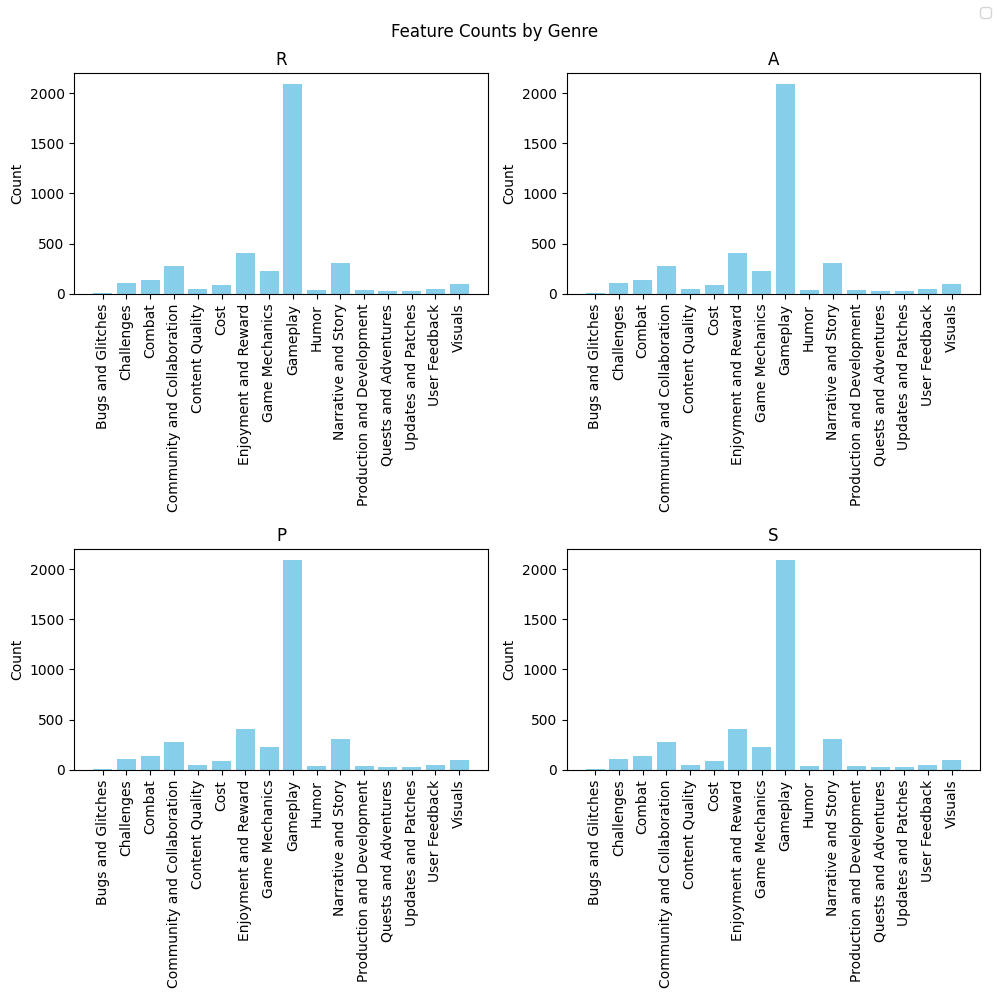

In [189]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

fig.legend()
fig.suptitle('Feature Counts by Genre')


categories_R = list(genre_category_counts['R'].keys())
counts_R = list(genre_category_counts['R'])
axs[0, 0].bar(categories_R, counts_R, color='skyblue')
axs[0, 0].set_title('R')
axs[0, 0].set_ylabel('Count')
axs[0, 0].tick_params(axis='x', rotation=90)


categories_A = list(genre_category_counts['A'].keys())
counts_A = list(genre_category_counts['A'])
axs[0, 1].bar(categories_R, counts_R, color='skyblue')
axs[0, 1].set_title('A')
axs[0, 1].set_ylabel('Count')
axs[0, 1].tick_params(axis='x', rotation=90)

categories_P = list(genre_category_counts['P'].keys())
counts_P = sorted(list(genre_category_counts['P'])
axs[1, 0].bar(categories_R, counts_R, color='skyblue')
axs[1, 0].set_title('P')
axs[1, 0].set_ylabel('Count')
axs[1, 0].tick_params(axis='x', rotation=90)

categories_S = list(genre_category_counts['S'].keys())
counts_S = list(genre_category_counts['S'])
axs[1, 1].bar(categories_R, counts_R, color='skyblue')
axs[1, 1].set_title('S')
axs[1, 1].set_ylabel('Count')
axs[1, 1].tick_params(axis='x', rotation=90)


plt.tight_layout()
plt.show()